In [1]:
from ipynb.fs.full.LSH import *
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from collections import Counter

Batches:   0%|          | 0/275 [00:00<?, ?it/s]


Target           : "Asees"
Target type      : "Movie"
Target genre(s)  : "dramas, international movies, music & musicals"

Similar Movies:
Name                                          Genres                                   Similarity
----------------------------------------------------------------------------------------------------
"25 Kille"                                    action & adventure, dramas, internati... 0.384
"Bombay"                                      dramas, international movies, romanti... 0.360
"Shakti: The Power"                           dramas, international movies, thrillers  0.349
"Kisaan"                                      action & adventure, dramas, internati... 0.344
"Pihu"                                        dramas, independent movies, internati... 0.336
"Pooja Kiven Aa"                              comedies, international movies, music... 0.327
"Uppena"                                      dramas, international movies, romanti... 0.322
"Rocks"   

In [2]:
# Building the distance matrix 
sample_idx = np.random.choice(len(df), size=400, replace=False)
distance_matrix = build_distance_matrix(sample_idx)


# Hierarchical Clustering

In [4]:
Z = linkage(squareform(distance_matrix, checks=False), method='average')

labels_hier = fcluster(Z, t=0.7, criterion='distance')

df['cluster'] = np.nan
df.loc[sample_idx, 'cluster'] = labels_hier
df['cluster'] = df['cluster'].astype('Int64')

print("Number of clusters:", df['cluster'].nunique())

Number of clusters: 394


# Hierarchical clustering dendogram

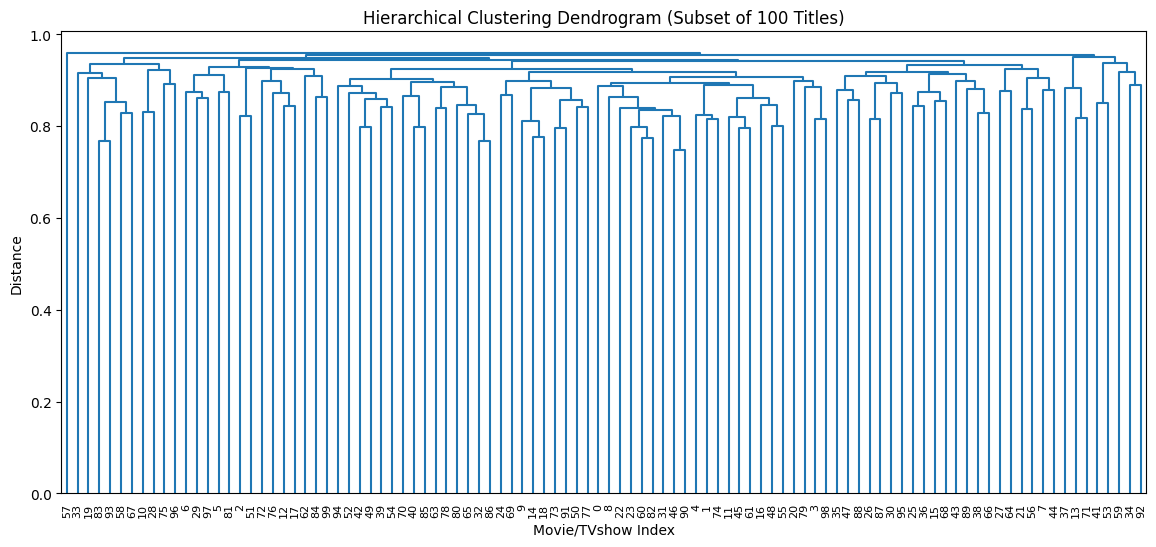

In [15]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

subset_size = 100
subset_idx = sample_idx[:subset_size]

D_small = distance_matrix[np.ix_(range(subset_size), range(subset_size))]
Z_small = linkage(squareform(D_small, checks=False), method='average')

plt.figure(figsize=(14, 6))
plt.title("Hierarchical Clustering Dendrogram (Subset of 100 Titles)")
plt.xlabel("Movie/TVshow Index")
plt.ylabel("Distance")
dendrogram(Z_small, leaf_rotation=90., leaf_font_size=8.)
plt.show()


---------------

In [5]:
def top_genres(series, k=5):
    tokens = []
    for s in series.dropna():
        tokens.extend([g.strip() for g in s.split(',') if g.strip()])
    return Counter(tokens).most_common(k)

def top_countries(series, k=5):
    tokens = []
    for s in series.dropna():
        tokens.extend([c.strip() for c in str(s).split(',') if c.strip()])
    return Counter(tokens).most_common(k)

def top_words_from_embeddings(indices, k=10):
    vecs = embedding_matrix[indices]
    mean_vec = vecs.mean(axis=0)
    top_dims = np.argsort(mean_vec)[-k:]
    return [f"dim{d}" for d in top_dims]


# Printing the clusters

In [6]:
subset = df.loc[sample_idx]
unique_clusters = sorted(subset['cluster'].dropna().unique())

for cid in unique_clusters[:10]:  # show first 10 clusters
    sub = subset[subset['cluster'] == cid]
    idxs = sub.index.tolist()
    
    print(f"\n=== Cluster {cid} | Size: {len(sub)} ===")
    print("Top Genres:", top_genres(sub['listed_in']))
    print("Top Countries:", top_countries(sub['country']))
    print("Top Embedding Dimensions:", top_words_from_embeddings(idxs))
    print("Example Titles:", "; ".join(sub['title'].head(5).tolist()))



=== Cluster 1 | Size: 1 ===
Top Genres: [('Dramas', 1), ('International Movies', 1), ('Sports Movies', 1)]
Top Countries: [('India', 1)]
Top Embedding Dimensions: ['dim4', 'dim209', 'dim54', 'dim265', 'dim263', 'dim30', 'dim275', 'dim207', 'dim312', 'dim138']
Example Titles: Azhar

=== Cluster 2 | Size: 1 ===
Top Genres: [('Documentaries', 1), ('Sports Movies', 1)]
Top Countries: [('United States', 1)]
Top Embedding Dimensions: ['dim117', 'dim251', 'dim37', 'dim244', 'dim115', 'dim232', 'dim263', 'dim380', 'dim14', 'dim235']
Example Titles: One in a Billion

=== Cluster 3 | Size: 1 ===
Top Genres: [('Action & Adventure', 1), ('Dramas', 1), ('International Movies', 1)]
Top Countries: [('India', 1)]
Top Embedding Dimensions: ['dim204', 'dim183', 'dim10', 'dim80', 'dim177', 'dim159', 'dim42', 'dim356', 'dim309', 'dim304']
Example Titles: Shootout at Lokhandwala

=== Cluster 4 | Size: 1 ===
Top Genres: [('Dramas', 1), ('International Movies', 1), ('Romantic Movies', 1)]
Top Countries: [('

# K-Means

In [7]:
from scipy.sparse import csr_matrix, hstack


emb_norm = embedding_matrix / np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
emb_sparse = csr_matrix(emb_norm)

meta = combined_features_matrix.copy()

row_norms = np.sqrt(meta.multiply(meta).sum(axis=1))  # sparse-safe
row_norms = np.asarray(row_norms).flatten()
row_norms[row_norms == 0] = 1.0

meta_norm = meta.multiply(1 / row_norms[:, None])   # stays sparse
meta_sparse = meta_norm * 0.6

X_hybrid = hstack([emb_sparse, meta_sparse], format='csr')

k = 20
km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048, n_init='auto')
labels_kmeans = km.fit_predict(X_hybrid)

df['cluster_kmeans'] = labels_kmeans
df['cluster_kmeans'].value_counts().head()

cluster_kmeans
9     733
13    698
2     671
16    630
4     537
Name: count, dtype: int64

# DBSCAN

In [8]:
distance_matrix_fixed = np.maximum(distance_matrix, 0)
np.fill_diagonal(distance_matrix_fixed, 0)

db = DBSCAN(metric='precomputed', eps=0.30, min_samples=5, n_jobs=-1)
labels_db = db.fit_predict(distance_matrix_fixed)

df['cluster_dbscan'] = np.nan
df.loc[sample_idx, 'cluster_dbscan'] = labels_db
df['cluster_dbscan'] = df['cluster_dbscan'].astype('Int64')


# PCA 2d visualization

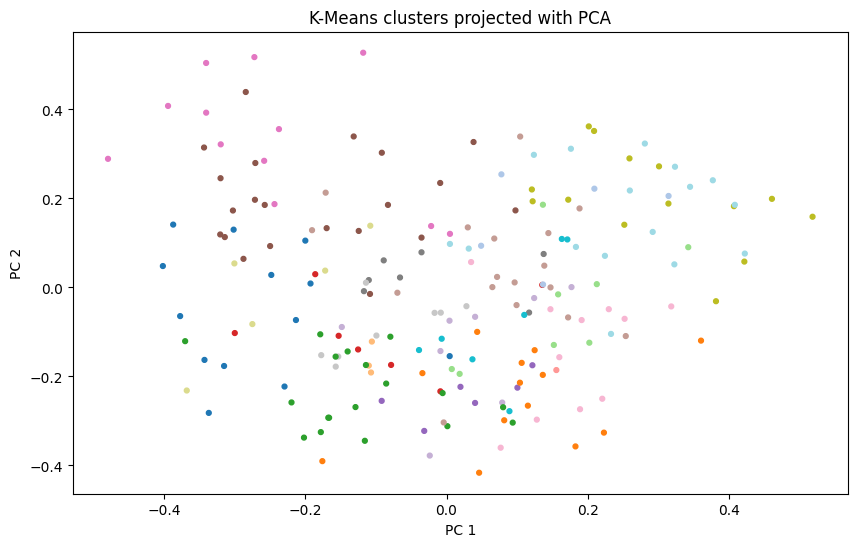

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_hybrid.toarray()[:200])  # use subset

plt.figure(figsize=(10,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_kmeans[:200], cmap='tab20', s=12)
plt.title("K-Means clusters projected with PCA")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()


# Davies-Bouldin Index

In [18]:
from sklearn.metrics import davies_bouldin_score

dbi = davies_bouldin_score(X_hybrid.toarray(), labels_kmeans)
print("Davies-Bouldin Index:", dbi)


Davies-Bouldin Index: 5.413998644228382


In [ ]:
which = 'cluster_kmeans'  # or cluster / cluster_dbscan
sizes = df[which].value_counts(dropna=True)

if -1 in sizes:
    sizes = sizes[sizes.index != -1]

for cid in sizes.index[:5]:
    sub = df[df[which] == cid]
    print(f"\n=== Cluster {cid} | Size: {len(sub)} ===")
    print(sub[['title','listed_in','country']].head(5).to_string(index=False))



=== Cluster 9 | Size: 733 ===
                                                title                                          listed_in                  country
                                 Dick Johnson Is Dead                                      Documentaries            United States
                               My Heroes Were Cowboys                                      Documentaries                      NaN
If I Leave Here Tomorrow: A Film About Lynyrd Skynyrd                    Documentaries, Music & Musicals            United States
                                              Q-Force Crime TV Shows, TV Action & Adventure, TV Comedies            United States
                      Crocodile Dundee in Los Angeles                       Action & Adventure, Comedies Australia, United States

=== Cluster 13 | Size: 698 ===
          title                                            listed_in                                                               country
        Sankofa   